In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import shelve
import string
import numba as nb
import timeit
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import colors
import matplotlib



In [2]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2]  
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen))
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def frk4closed_step(y,p,pvec,Wout,w,h,N):
    k1 = h * fkura_closed( y,p,pvec,Wout,w,N)
    k2 = h * fkura_closed(y + 0.5 * k1, p,pvec,Wout,w,N)
    k3 = h * fkura_closed( y + 0.5 * k2, p,pvec,Wout,w,N)
    k4 = h * fkura_closed(y + k3, p,pvec,Wout,w,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))
    
@nb.njit()
def fkura_closed(x,p,pvec,Wout,w,N):  
    uin, K,F = p[0],p[1],p[2]
    one_hot = pvec   
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))  
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i]) 
    return y

def unroll_parameter(p_dict):
    N = p_dict['N']
    K = p_dict['K']
    uin = p_dict['uin']
    h = p_dict['h']
    mu = p_dict['mu']
    sigma = p_dict['sigma']
    w = p_dict['w']
    F = p_dict['F']
    reg = p_dict['reg']
    one_hot = p_dict['one_hot']
    testlen = p_dict['test']
    trainlen = p_dict['train']
    initlen = p_dict['init']
    data_scale = p_dict['data_scale']
    return N,K,uin,h,mu,sigma,w,F,reg,one_hot,testlen,trainlen,initlen,data_scale

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def nb_concatdot30( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1]
            res[1]+=x[1,i]*y[i-1]
            res[2]+=x[2,i]*y[i-1]
    return res

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 


def training(data_scaled,p,pvec,w,h,N,initlen=2500,trainlen=10_000):
    ut0 =np.eye(3)[pvec] @ data_scaled[:,::20]
    utmid =np.eye(3)[pvec] @ data_scaled[:,10:][:,::20]
    ut1 =np.eye(3)[pvec] @  data_scaled[:,20:][:,::20]

    x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
    X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

    X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)


    Yt = data_scaled [:,::20][:,(initlen+1):(initlen+trainlen+1)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)
    nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

    u0 = Yt.T[:,-1]
    x0= X0[:,-1] 

    return x0,Wout,nmse_train


def test_closed(x0,p,pvec,Wout,w,h,N,s_steps):
    Xtest=np.zeros((N,s_steps), dtype='float64')
    Upred=np.zeros((3,s_steps), dtype='float64')
    x=x0
    for i in nb.prange(s_steps):
        x = frk4closed_step(x,p,pvec,Wout,w,h,N)
        Xtest[:,i] = x
        Upred[:,i]= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    return Xtest, Upred




In [3]:

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

In [4]:
with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['lorenz']


N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
data_scaled = data/data_scale
data_sampled= data_scaled [:,::20]

In [5]:
N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
p = np.array([uin, K,F])
K,F= p[1],p[2]

testlen=10_000
x0,Wout,nmse_train = training(data_scaled,p,one_hot_output,w,h,N,initlen=initlen,trainlen=trainlen)
Xpred, Upred=test_closed(x0,p,one_hot_output,Wout,w,h,N,testlen)

In [6]:
rtest= np.sqrt((np.cos(Xpred).sum(axis=0))**2+(np.sin(Xpred).sum(axis=0))**2)/N
T=np.arange(100,200,0.01)

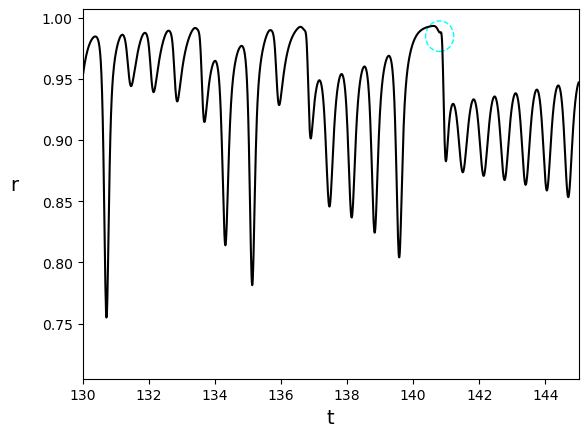

In [60]:
circle = matplotlib.patches.Ellipse((140.8, 0.985), 0.85, 0.025,linestyle='--', color='cyan',fill=False)

plt.plot(T,rtest,'black')
plt.xlim([130,145])
plt.xlabel('t',fontsize=14)
plt.ylabel('r',rotation=0,fontsize=14,labelpad=20)
plt.gca().add_patch(circle)
plt.savefig(f'ranom_a.jpg',dpi=200,bbox_inches = 'tight')



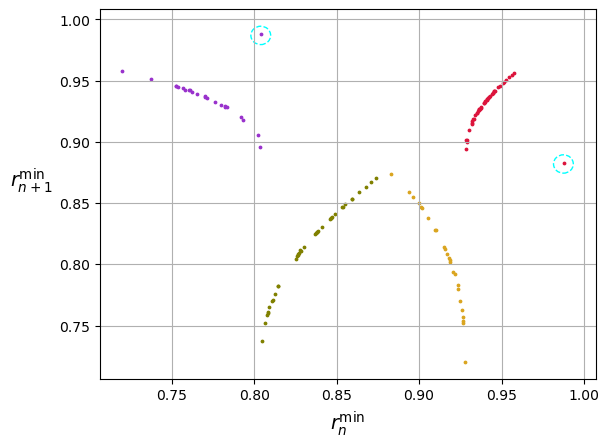

In [56]:
drmin = []
ilist = []

circle1 =matplotlib.patches.Ellipse((0.804, 0.987), 0.012,0.015,linestyle='--', color='cyan',fill=False)
circle2 = matplotlib.patches.Ellipse((0.9875, 0.882), 0.012,0.015,linestyle='--', color='cyan',fill=False)



d1 = 0.805
d2 = 0.875
d3 = 0.9281
d4 = 1

dr= rtest[1:] - rtest[:-1]
for i in range(0,len(dr)-1):
    if dr[i]<0 and dr[i+1]>0:
        drmin.append((rtest[i]+rtest[i+1])/2)
        ilist.append(i)
drmin = np.array(drmin)
plt.scatter(drmin[:-1][drmin[:-1]<d1], drmin[1:][drmin[:-1]<d1],s=3,label='$I_1$',color='darkorchid')
plt.scatter(drmin[:-1][ (drmin[:-1]>d1)*(drmin[:-1]<d2) ], drmin[1:][(drmin[:-1]>d1)*(drmin[:-1]<d2)],color='olive',s=3,label='$I_2$')
plt.scatter(drmin[:-1][ (drmin[:-1]>d2)*(drmin[:-1]<d3) ], drmin[1:][(drmin[:-1]>d2)*(drmin[:-1]<d3)],color='goldenrod',s=3,label='$I_3$')
plt.scatter(drmin[:-1][ (drmin[:-1]>d3)*(drmin[:-1]<d4) ], drmin[1:][(drmin[:-1]>d3)*(drmin[:-1]<d4)],color='crimson',s=3,label='$I_4$')
plt.xlabel('$r_n^{\min}$',fontsize=14, rotation =0 )
plt.ylabel('$r_{n+1}^{\min}$', fontsize=14,rotation =0,labelpad=20)
plt.grid()
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.savefig(f'ranom_b.jpg',dpi=200,bbox_inches = 'tight')

In [66]:


drmax = []
ilist = []
dr= -(rtest[1:] - rtest[:-1])
for i in range(0,len(dr)-1):
    if dr[i]<0 and dr[i+1]>0 and abs(dr[i]-dr[i+1])<0.001/5:
        drmax.append((rtest[i]+rtest[i+1])/2)
        ilist.append(i)
iarray=np.array(ilist)[:-1]
rmax= np.array(drmax)
rx = rmax[:-1]
ry = rmax[1:]

dom1 = rx<0.969
dom2 = ((rx>0.969) & (ry>0.985) & (rx<0.984)) | ((rx>0.985) & (rx < 0.99) & (ry < 0.986) & (ry>0.94)) | \
((rx>0.991) & (ry < 0.9805) & (ry > 0.9795))
dom3 = ((rx<0.9849) & (ry<0.9859) & (rx >0.97)) |  ((rx>0.9849) & (rx < 0.9901 ) & (ry> 0.9859))
dom4 = ((rx>0.9906) & (ry < 0.979) )| ((rx>0.9901) & (ry > 0.9805) & (ry<0.99))
dom5= (rx>0.98) & (ry<0.94)

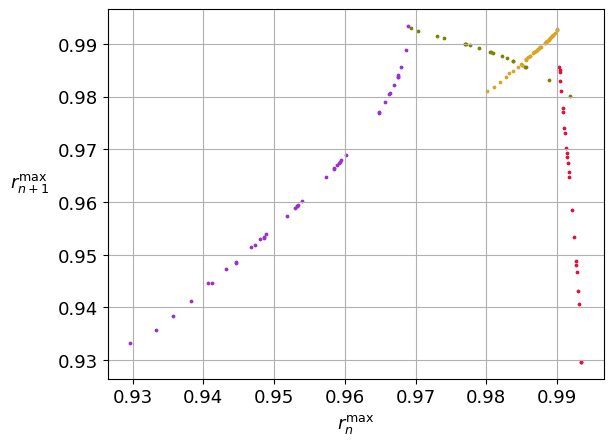

In [67]:
plt.scatter(rx[dom1],ry[dom1],s=3, color='darkorchid')
plt.scatter(rx[dom2],ry[dom2],s=3,color='olive')
plt.scatter(rx[dom3],ry[dom3],s=3, color='goldenrod')
plt.scatter(rx[dom4],ry[dom4],s=3,color='crimson')
plt.scatter(rx[dom5],ry[dom5],s=3,color='crimson')
#plt.scatter(rx,ry,s=40,color='blue', alpha=0.1)
plt.xlabel('$r_n^{\max}$',fontsize=13, rotation =0 )
plt.ylabel('$r_{n+1}^{\max}$', fontsize=13,rotation =0,labelpad=20)
plt.grid()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(f'rmax.jpg',dpi=200,bbox_inches = 'tight')

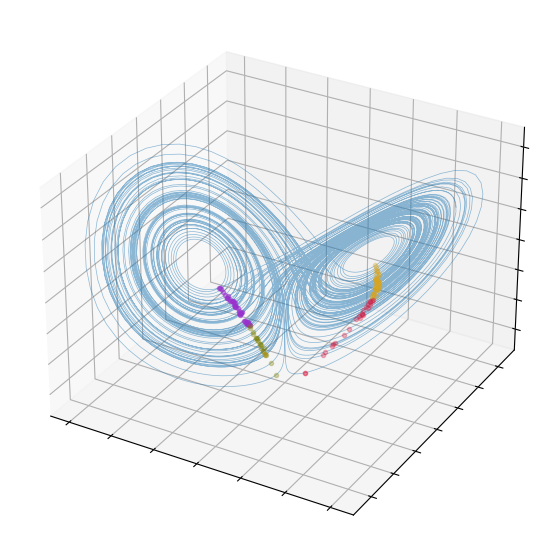

In [49]:
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.plot(*Upred, lw=0.5,alpha=0.5, label= 'data')
ax.plot(*Upred[:,iarray[dom1]],'.', color='darkorchid',lw=0.5,alpha=0.5, label='$I_1$')
ax.plot(*Upred[:,iarray[dom2]],'.', color='olive',lw=0.5, alpha=0.3,label='$I_2$')
ax.plot(*Upred[:,iarray[dom3]],'.', lw=0.5,alpha=0.3, color='goldenrod', label='$I_3$')
ax.plot(*Upred[:,iarray[dom4]],'.', lw=0.5, alpha=0.3,color='crimson',label='$I_4$')
ax.plot(*Upred[:,iarray[dom5]],'.', lw=0.5, alpha=0.3, color='crimson',label='$I_4$')

ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
plt.savefig(f'rmax3d2.jpg',dpi=200,bbox_inches = 'tight')